<a name="top"></a>

<div style="width:1000 px">
<div style="float:right; width:300 px"><img src="https://github.com/brianmapes/ATM407/blob/master/images/EnergyMassPlot_spaghettiplot.png?raw=true" alt="(EnergyMassPlot example image here)" style="height: 200px;"></div>

<h1>Parcel Theory: Lifted parcel density calculations</h1>
<h3>Wei-Ming Tsai, Apr. 2019, ATM663 Final Project</h3>

This notebook computes lifted parcel buoyancy, in a sounding from this Web archive:
http://weather.uwyo.edu/upperair/sounding.html

Comparing full entropy treatment to simple static energy

0. <a href="#MSEplot">Grab sounding and make static energy plot</a>
1. <a href="#functions">Define thermo functions
1. <a href="#plots">Basic plots: MSE and entropy versions</a>
1. <a href="#b_from_s">Undilute parcel buoyancy: entropy conserving</a>
1. <a href="#pseudo">Pseudoadiabatic vs. reversible</a>
1. <a href="#b_from_h">Undilute parcel buoyancy: MSE conserving</a>
1. <a href="#entraining">Entraining plume of MSE</a>
1. <a href="#CAPE">CAPE of entraining plume of MSE</a>
1. <a href="#sens">Sensitivity of CAPE of entraining plume of MSE</a>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

# Introduction 

This final project is using a 1-D parcel model to understand (1) the sensitivity of buoyancy and CAPE to thermodynamic variations over different levels, and (2) entraiment effects on parcel buoyancy using a constant entrainment rate and entrainment rates varying with height.
Several soundings are considered in this study. <br>

2018 JJA tropical land v.s. tropical ocean soundings


<a name="MSEplot"></a> 
# Select a sounding, and plot it
#### After importing necessary modules 

In [1]:
%pylab inline
# makes plots appear inline in the notebook, cheaty/simple way

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import MSEplots.plots as mpt

import metpy.calc as mpcalc
from metpy import units
from metpy.constants import Cp_d,Lv,Rd,g 
from metpy.calc.thermo import *

#### Date format is YYYY, M, D, H. 
#### Station codes can be found using the selectors here:  
http://weather.uwyo.edu/upperair/sounding.html

In [3]:
from siphon.simplewebservice.wyoming import WyomingUpperAir

date = datetime(2018, 8, 24, 12)
# station = 'SKBO' mountain station in Colombia avail. 2018-11-24-12
station = 'PKMJ'
#date = datetime(2019, 3, 28, 12)

df = WyomingUpperAir.request_data(date, station)
p = df['pressure'].values #hPa
T = df['temperature'].values  #C
Td = df['dewpoint'].values #C
Z = df['height'].values   #m

r = mixing_ratio( saturation_vapor_pressure(Td*units.units('degC')), p*units.units('hPa') ) 
q = specific_humidity_from_mixing_ratio(r)
rs = mixing_ratio( saturation_vapor_pressure(T*units.units('degC')), p*units.units('hPa') ) 
qs = specific_humidity_from_mixing_ratio(rs)

Text(0.5, 1.0, 'Wyoming Upper Air, Majuro (7.07N, 171.29E), 2018/08/24')

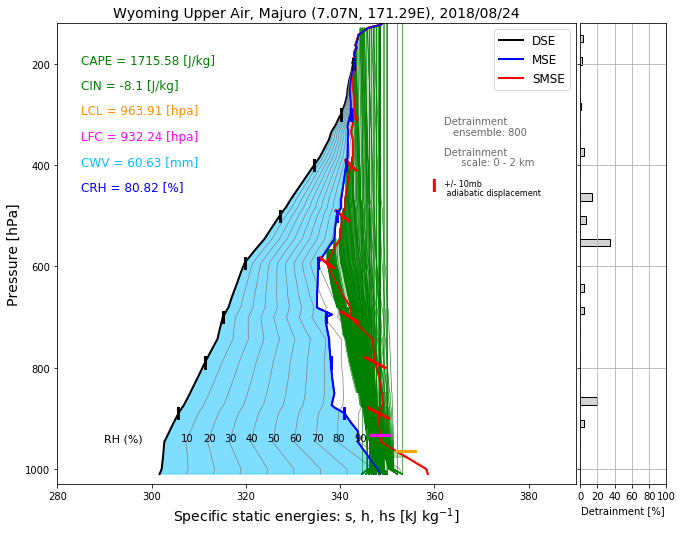

In [4]:
ax = mpt.msed_plots(p,T,q,Z,ent_rate=np.arange(0,2,0.05),entrain=True) # altitude included
ax.set_title('Wyoming Upper Air, Majuro (7.07N, 171.29E), 2018/08/24', fontsize=14)

-------------
<a name="functions"></a>
# Functions needed for moist thermo calculations

In [5]:
# Package of thermo functions 

import numpy as np

def esat(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        #return 0

# This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )
# This one is over ice, but valid at subzero temperatures only
#    ESATI = np.exp( 23.33086 - 6111.72784/(T+Tref) + 0.15215*np.log(T+Tref) )

# Water only  
    return ESAT 



def esati(T):
# Saturation vapor pressure IN HPA as a function of temperature IN CELSIUS
    if( np.max(np.abs(T)) > 100 ) :
        print, 'esat: Please provide T in CELSIUS ', np.max(np.abs(T))
        return 0

# This one is from Emanuel page 116 (4.4.13), over liquid at all temperatures
    Tref = 273.15
    ESAT = np.exp( 53.67957 - 6743.769/(T+Tref) - 4.8451*np.log(T+Tref) )
# This one is over ice, but valid at subzero temperatures only
    ESATI = np.exp( 23.33086 - 6111.72784/(T+Tref) + 0.15215*np.log(T+Tref) )

# Stitch them together into the optput array based on sign of T in C    
    return np.where(T>0, ESAT,ESATI)


def mixrat(Td,p):
# Td in C# p in mb
    if( np.max(np.abs(Td)) > 100 or np.max(np.abs(p)) > 1050) :
        print, 'mixrat: provide Td in C, p in mb',np.max(np.abs(Td)),np.max(np.abs(p))
        #return 0

# simple formula with 0.622 rato of molecular weight or R vapor vs. air    
    es = esat(Td)
    return 0.622 * es / (p-es)


def entropy(T,p,qtot): 

# T in C, p in mb, qtot in kg/kg
    if( np.max(T) > 100. or np.max(np.abs(p)) > 1050. or np.max(np.abs(qtot)) > 0.1 ):
        print( 'entropy: provide T in centigrade, p in mb, qtot in kg/kg') 
        print( T,p,qtot )
        return 0

# from Raymond & Blyth 1992
    Tref = 273.15 
    pref = 1000.0
    Cpd = 1005.		# dry air heat capacity at const p
    Cpv = 1850.		# water vapor heat capacity at const p
    Rv = 461.51		# Gas constant for vapor
    Rd = 287.05		# Gas constant for dry air
    Lref = 2.501e6 		# vaporization heat at Tref
    Cl  =  4218.		# liquid water heat capacity
    eref = 6.106		# sat p at Tref (mb)

    L = Lref - (Cl - Cpv)*T		# T ARRAY IN CENTIGRADE

    qsat = mixrat(T,p)
    qv = np.where(qtot < qsat,qtot, qsat)
    e = esat(T) *qv/qsat

    s = (Cpd + qtot*Cl)*np.log( (T+Tref)/Tref ) - Rd*np.log( (p-e)/pref ) + \
        L*qv/(T+Tref) - qv*Rv*np.log(qv/qsat)

    return s



def invert_entropy(sm,qt,p):
# Inverts entropy sm & total water qt at pressures p (mb) 
# Returns T & qv vapor mixing ratio
# Met units: mb, C, kg/kg 

    LOOPMAX =  100 #  /* max number of iteration loops */

#/* invert the entropy equation -- use Newton's method. Measure ds for dT=1K

    ts = 200.0 + p/10. - 273.16	 # crude first guess (C)    
    for i in range(0, LOOPMAX+1):
        fs0 = entropy(ts,p,qt) - sm
        fs1 = entropy(ts - 1.,p,qt) - sm
        dts = fs0/(fs1 - fs0) # dT/ds * (entropy error of guess ts)
        ts  = ts+dts          # correct that guess, linearized way
        
        #print('loop iteration i',i,'largest error is:', np.max(np.abs(dts)))

        if (np.max(np.abs(dts)) < .01): break # this will end the loop 
        if (i == LOOPMAX - 1):
            print( "s invert not converging" )
            return 0
                
# gather up result and return it
    T = ts   # latest guess from iteration
    qvsat = mixrat(T,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return T,qv 


def MSE(T,Z,qv): # units C, m, kg/kg
    Cp = 1005.		# dry air heat capacity at const p
    L = 2.501e6 		# vaporization heat at Tref
    g = 9.8 
    Tref = 273.16
    
    return Cp*(T+Tref) + g*Z + L*qv


def invert_MSE(h,qt,Z,p):
# Inverts h value & total water qt at a set of heights Z (in m) and pressures p (in mb)
# Returns T & qv vapor mixing ratio of parcel
# Met units: m, C, kg/kg, mb

#/* invert the transitive MSE equation -- use Newton's method
    LOOPMAX =  100 #  /* max number of iteration loops */

    ts = h*0 +20 -6*Z/1000. # crude first guess at T (6 K/km lapse rate)

# Now iterate
    for i in range(0, LOOPMAX+1):
        
    # The MSE profile based on guess ts and min(qt,qvsat)
        qsat0 = mixrat(ts, p)
        qv0 = np.where(qt<qsat0,qt, qsat0)
        MSE0 = MSE(ts,   Z, qv0      ) 

    # now MSE profile for a +1K perturbation
        qsat1 = mixrat(ts+1, p)
        qv1 = np.where(qt<qsat1,qt, qsat1)
        MSE1 = MSE(ts+1,Z, qv1) 
        
    # So we can estimate the derivative dMSE/dT
        dMSEdT = MSE1-MSE0      # J/kg per K 
        
    # Use that derivative to estimate the correction to the guess ts
        dts = (h-MSE0)/dMSEdT # convert MSE error of first guess ts to K units
        ts  = ts+dts          # correct initial T guess using that slope
            
    # test if correction is small, and quit if so. Otherwise, repeat. 
        if (np.max(np.abs(dts)) < .01): break # end loop 
        if (i == LOOPMAX - 1) :
            print( "MSE invert not converging" )
            #return 0
                
# After the corrections have converged, gather up result and return it
    qvsat = mixrat(ts,p)		#/* saturation mixing ratio at computed temp */
    qv = np.where(qt < qvsat,qt, qvsat)      #/* check for saturation */

    return ts,qv 


---------------
<a name="plots"></a>
# Plot the static energy and entropy 3-curve plots  

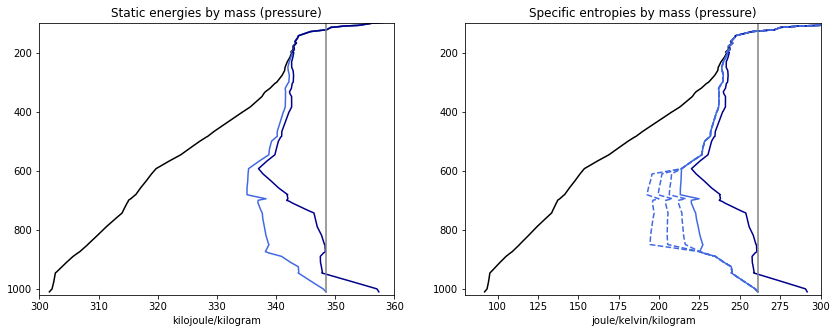

In [203]:
fig = plt.figure(figsize=(14,5))

s = MSE(T,Z,q*1e-9) /1000*units.units('kJ/kg')
h = MSE(T,Z,q)      /1000*units.units('kJ/kg')
hs = MSE(T,Z,qs)    /1000*units.units('kJ/kg')

ax1 = plt.subplot(1,2,1)
ax1.plot(s, p, 'k')
ax1.plot(h, p, 'royalblue')
ax1.plot(hs, p, 'darkblue')
ax1.set_xlim([300,360]); ax1.set_ylim([1020,100]); ax1.set_title('Static energies by mass (pressure)')
ax1.plot(h*0+h[0],p,'grey')

sd = entropy(T,p,q*1e-6) *units.units('J/kg/K')
sm = entropy(T,p,q)      *units.units('J/kg/K')
sms = entropy(T,p,qs)    *units.units('J/kg/K')
cwv = mpcalc.precipitable_water(Td*units.units('degC'),p*units.units('mbar'))

# reduce 10%, 20%, 30% lower level qv, 850-600mbar [10:26]
qv_mod = np.ones((3,len(q)))*q
sm_mod = np.zeros((3,len(q)))
sms_mod = sm_mod.copy();Td_mod = sm_mod.copy(); cwv_mod = np.zeros(3)

for n in range(3):
    qv_mod[n,10:26] = q[10:26]*(1-0.1*(n+1))  
    sm_mod[n,:] = entropy(T,p,qv_mod[n,:])
    sms_mod[n,:] = entropy(T,p,qs)
    
    Td_mod[n,:] = dewpoint_from_specific_humidity(qv_mod[n,:],T*units.units('degC'),p*units.units('mbar'))
    cwv_mod[n] = mpcalc.precipitable_water(Td_mod[n,:]*units.units('degC'),p*units.units('mbar')).magnitude

ax2 = plt.subplot(1,2,2)
ax2.plot(sd, p, 'k')
ax2.plot(sm, p, 'royalblue')
ax2.plot(sms, p, 'darkblue')
for n in range(3):
    ax2.plot(sm_mod[n,:], p,'--',color='royalblue')

ax2.set_ylim([1020,100]); ax2.set_xlim([80,300]); ax2.set_title('Specific entropies by mass (pressure)')
ax2.plot(sm*0+sm[0],p,'grey')

In [204]:
cwv_mod

array([58.55283922, 56.04181308, 53.54347836])


---------------
<a name="b_from_s"></a>
# Compute parcel b (as T excesses), conserving entropy and qtot
### a "reversible" moist adiabat

Text(0.5, 1.0, 'Tenv and T of entropy and qtot conserving parcel')

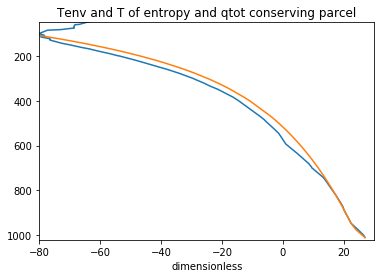

In [54]:
sm = entropy(T,p,q)      #*units.units('J/kg/K')
qtot = q[0] # total water content
Tp,qvp = invert_entropy(sm[0],qtot, np.where(p>50,p,50))

plot(T,p); plot(Tp,p)
ylim([1020,50]); xlim([-80,30]); title('Tenv and T of entropy and qtot conserving parcel')

In [8]:
# http://glossary.ametsoc.org/wiki/Virtual_temperature

def Tv(T,qv): 
    Tref = 273.16
    return (1 + 0.61*qv)*(T+Tref) - Tref # virtual temperature

def Trho(T,qv,qc): 
    Tref = 273.16
    return (1 + 0.61*qv -qc)*(T+Tref) - Tref # density temperature, considering condensed water loading

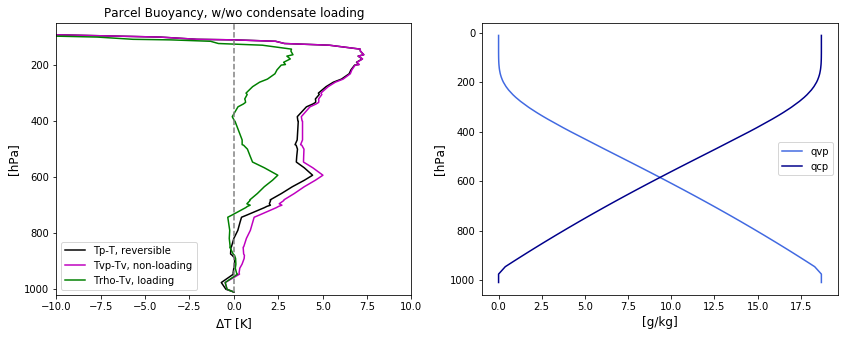

In [9]:
qcp = qtot - qvp

fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(Tp-T,p,'k')
ax1.plot( Trho(Tp,qvp,0)-Tv(T,q) ,p,'m')
ax1.plot( Trho(Tp,qvp,qcp)-Tv(T,q),p ,'g'); plot(p*0,p,'--',color='grey') # less buoyant due to condensed water loading
ax1.set_ylim([1020,50]); ax1.set_xlim([-10,10]); ax1.set_title('Parcel Buoyancy, w/wo condensate loading')
ax1.legend(['Tp-T, reversible','Tvp-Tv, non-loading','Trho-Tv, loading'])
ax1.set_xlabel('$\Delta$T [K]',fontsize=12)
ax1.set_ylabel('[hPa]',fontsize=12)

ax2 = plt.subplot(1,2,2)
ax2.plot(qvp*1000,p,'royalblue')
ax2.plot(qcp*1000,p,'darkblue')
ax2.set_xlabel('[g/kg]',fontsize=12)
ax2.set_ylabel('[hPa]',fontsize=12)
ax2.invert_yaxis()
ax2.legend(['qvp','qcp'])

dTrho_entropy = Trho(Tp,qvp,qcp)-Tv(T,q)

Green and purple lines overlap below 963hpa (LCL) where water vapor in the rising parcel is not saturated yet.
Total water content is conserved during the reversible process.


---------------
<a name="pseudo"></a>
# Instead of conserving qtot, let qt at every level be qv of parcel
### a "pseudo-adiabatic" moist adiabat; all condensate assumed gone from parcel

Text(0.5, 1.0, 'Reversible vs. pseudo-adiabatic Trho excesses')

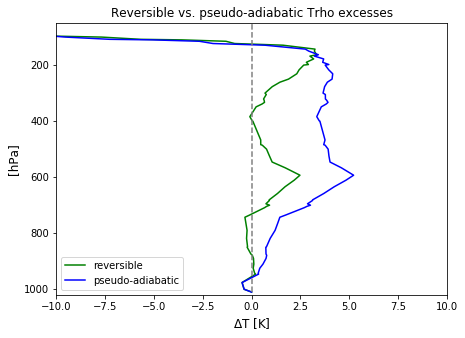

In [10]:
Tp_precip,qvp_precip = invert_entropy(sm[0],qvp, np.where(p>100,p,100)) # assume reversible

# Ultimate parcel-env density indicator T_rho

#plot( Trho(Tp,       qvp,       0  )-Tv(T,q) ,p, 'g'); plot(p*0,p)  
#plot( Trho(Tp_precip,qvp_precip,qcp)-Tv(T,q) ,p, 'b'); plot(p*0,p) 

fig = plt.figure(figsize=(7,5))
plot( Trho(Tp,       qvp,       qcp  )-Tv(T,q) ,p, 'g') # reversible 
plot( Trho(Tp_precip,qvp_precip, 0)-Tv(T,q) ,p, 'b'); plot(p*0,p,'--',color='grey') # persudo-adiabatic
ylabel('[hPa]',fontsize=12); xlabel('$\Delta$T [K]',fontsize=12)
plt.legend(['reversible','pseudo-adiabatic'])

ylim([1020,50]); xlim([-10,10]); title('Reversible vs. pseudo-adiabatic Trho excesses')


---------------
<a name="b_from_h"></a>
# Compute parcel b (as T excesses), conserving MSE and q (total water)

### ["MSE minus CAPE is the true conserved variable"](https://journals.ametsoc.org/doi/10.1175/JAS-D-15-0054.1)

In [52]:
s = MSE(T,Z,q*1e-9) #/1000*units.units('kJ/kg')
h = MSE(T,Z,q)      #/1000*units.units('kJ/kg')
hs = MSE(T,Z,qs)    #/1000*units.units('kJ/kg')

TpMSE,qvpMSE = invert_MSE(h[0],q[0], np.where(Z<18000.,Z,18000.), np.where(p>100.,p,100.))
qcpMSE = q[0]-qvpMSE

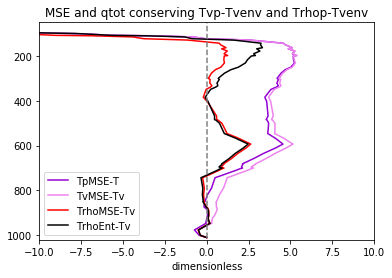

In [16]:
plot(TpMSE-T,p,'darkviolet')
plot( Tv(TpMSE,qvpMSE)-Tv(T,q) ,p, 'violet') 
plot( Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) ,p, 'r') # MSE-conserved T

ylim([1020,50]); xlim([-10,10]); title('MSE and qtot conserving Tvp-Tvenv and Trhop-Tvenv')
plot( dTrho_entropy ,p,'k'); plot(p*0,p,'--',color='grey') # entropy
plt.legend(['TpMSE-T','TvMSE-Tv','TrhoMSE-Tv','TrhoEnt-Tv'])

dTrho_MSE = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q)

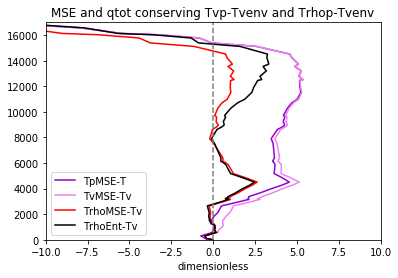

In [17]:
# Z coord plot as it becomes CAPE = integral (b dZ)
plot(TpMSE-T,Z,'darkviolet')
plot( Tv(TpMSE,qvpMSE)-Tv(T,q) ,Z, 'violet')
plot( Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q) ,Z, 'r')

ylim([0,17000]); xlim([-10,10]); title('MSE and qtot conserving Tvp-Tvenv and Trhop-Tvenv')
plot( dTrho_entropy ,Z, 'k'); plot(p*0,Z,'--',color='grey')
plt.legend(['TpMSE-T','TvMSE-Tv','TrhoMSE-Tv','TrhoEnt-Tv'])


dTrho_MSE = Trho(TpMSE,qvpMSE,qcpMSE)-Tv(T,q)

## Considering the effect of latent heat of freezing
The pseudo-adiabatic process shows departure from observed tropical conditions, such as complete fallout of condensate (100% precipitaiton efficiency). The reversible process indicates that condensate is carried all the way to the upper level without precipitation or transfromation into the ice phase. Williams and Renno (1992) argued that a reversible process with ice is more accurate comparing to the previous two and shows consistent to observed characteristics of deep convection, such as enough CAPE, upper cirrus, and lightning activities. 

In [169]:
# esati, mixrat
def mixrat_i(T,p):
    es = esati(T)
    return 0.622*es/(p-es)

def delT4ice(Tp,p,qcp,qvp,Tf=-10):
# computes delta T, an increase in temperature due to latent heat of freezing and the deposition 
# of water vapor on ice (Iribarne and Godson, 1981 eq.94)
    Tref = 273.15 # reference Temp.
    Ls = 2.83e6 # J/kg, latent heat of sublimation
    Lf = 3.34e5 # J/kg, latent heat of freezing
    Cpd = 1005  # J/kg
    Cpv = 1996  # J/kg
    Cpi = 2108  # J/kg
    Rv = 461.51 # J/K/kg
    
    LOOPMAX = 200 # iteration number
    
    fg0 = -8*np.ones(len(Tp))   # first guess
    k = np.zeros(len(Tp))
    
    for i in range(0, LOOPMAX+1):
                
        rs = qcp + mixrat(Tp,p) - mixrat_i(fg0,p)
        Cpt = Cpd + mixrat(Tp,p)*Cpv + rs*Cpi       
        a = ( Lf*qcp + Ls*qvp*(1-esati(Tp)/esat(Tp)) )
        b = (Cpt + mixrat_i(fg0,p)*Ls**2/(Rv*(Tp+Tref)**2))
        delT = a / b
        
        print(len(delT))
        if np.max(np.abs(delT-k)) < 1e-2:
            break
            fg0 = Tf + delT
        
        else:
            k = delT
            fg0 = Tf + delT
        
        #if np.max(fg0-(Tf+delT)) < 0.01: 
        #    break
        #    Tdev = Tf + delT
        #    Tdev = np.where(Tp < -10, Tdev, Tp)

        #else:
        #    fg0 = Tf + delT            
            
        #if (i == LOOPMAX - 1):
        #    print( "s invert not converging" )    
    
    print(i)
    
    Tdev = np.where(Tp < -10, fg0, Tp)
    return Tdev

        #fs0 = entropy(ts,p,qt) - sm
        #fs1 = entropy(ts - 1.,p,qt) - sm
        #dts = fs0/(fs1 - fs0) # dT/ds * (entropy error of guess ts)
        #ts  = ts+dts          # correct that guess, linearized way
        
        #print('loop iteration i',i,'largest error is:', np.max(np.abs(dts)))

        #if (np.max(np.abs(dts)) < .01): break # this will end the loop 
        #if (i == LOOPMAX - 1):
        #    print( "s invert not converging" )
        #    return 0

In [205]:
Tdev = delT4ice(Tp,p,qcp,qvp,Tf=-10)

111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
36


(0, 18)

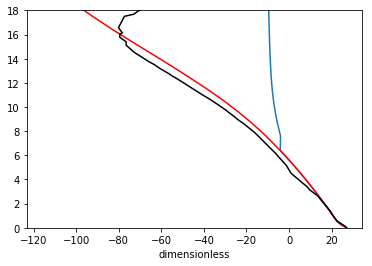

In [206]:
plot(Tdev,Z/1000)
plot(Tp,Z/1000,'r')
plot(T,Z/1000,'k')
ylim([0,18])

1. <a href="#b_from_s">Compare to entropy conserving</a>

### This near neutrality is what [this fuss about no CAPE](https://journals.ametsoc.org/doi/10.1175/1520-0493%281989%29117%3C1471%3AITTACU%3E2.0.CO%3B2) was about in the 1980s-1990s, later reconciled [here](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493%281993%29121%3C0021%3AAAOTCI%3E2.0.CO%3B2) with ice freezing latent heat counted. 

#### My take on this, based on learning the present entropy treatment (from [Raymond Blyth 1992](https://journals.ametsoc.org/doi/10.1175/1520-0469%281986%29043%3C2708%3AASMMFN%3E2.0.CO%3B2), who cite Iribarne and Godson textbook), is [here](https://rmets.onlinelibrary.wiley.com/doi/pdf/10.1002/qj.49712757708) in QJRMS 2000 [free pdf](https://pdfs.semanticscholar.org/858e/a28dd01bc3113e718b2ac90e1fae0ace487a.pdf).

#### ["MSE minus CAPE is the true conserved variable"](https://journals.ametsoc.org/doi/10.1175/JAS-D-15-0054.1)


---------------
<a name="entraining"></a>
# Compute parcel b (as T excess), not conserving h and q 
## but entraining with rate $\epsilon$
#### $M_z = \epsilon M$ for mass flux M
#### $h_z = \epsilon (h_{env}-h)$ for specific scalar h 

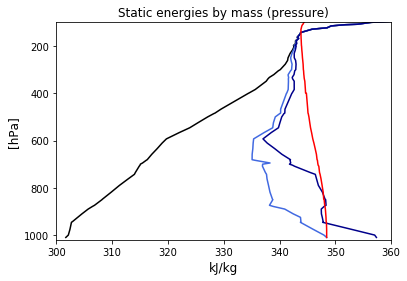

In [18]:
# entraining plume
epsilon = 1.0/15000. # 100% per 15 km vertical rise 

s = MSE(T,Z,q*1e-9)  #*units.units('kJ/kg')
h = MSE(T,Z,q)       #*units('kJ/kg')
hs = MSE(T,Z,qs)     #*units('kJ/kg')

plot(s/1000, p, 'k')
plot(h/1000, p, 'royalblue')
plot(hs/1000, p, 'darkblue')
xlabel('kJ/kg',fontsize=12);ylabel('[hPa]',fontsize=12)
xlim([300,360]); ylim([1020,100]); title('Static energies by mass (pressure)')
#plot(h*0+h[0],p) # undilute 


# entrainment for the conserved variable
dZ = np.gradient(Z)

hplume = h*0 + h[0] # initial value equal to undilute surface parcel
qplume = q*0 + q[0] # initial value equal to undilute surface parcel

for iz in arange(1,size(h)): 
    hplume[iz] = hplume[iz-1] + epsilon*dZ[iz-1]*( h[iz-1] - hplume[iz-1] )
    qplume[iz] = qplume[iz-1] + epsilon*dZ[iz-1]*( q[iz-1] - qplume[iz-1] )

plot(hplume/1000, p, 'r') # entrained plume

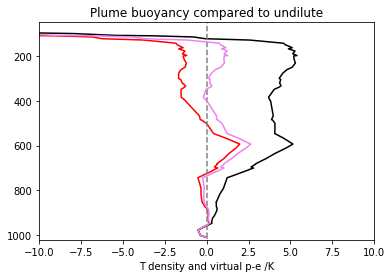

In [19]:
Tplume,qvplume = invert_MSE(hplume,qplume, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcplume = qplume - qvplume

plot( Trho(Tplume,qvplume,qcplume)-Tv(T,q) ,p, 'r')
plot( Tv(TpMSE,qvpMSE)-Tv(T,q) ,p, 'k'); plot(p*0,p,'--',color='grey')

ylim([1020,50]); xlim([-10,10]); 
title('Plume buoyancy compared to undilute'); xlabel('T density and virtual p-e /K')

plot( dTrho_MSE ,p ,'violet') # condensate loading

## Entrainment formulations: deep inflow mixing 
(Holloway and Neelin, 2009; Schiro and Neelin 2019) <br>
Constructing the entrainment formula as a function of mixing coefficients at all levels, instead of a constant mixing rate, $\epsilon$

\begin{equation*}
r_k = (1 - X_{k-1})r_{k-1} + X_{k-1}\hat{r}_{k-1}
\end{equation*}
where $r$ is the conserved variable, r_hat is its environmental value and $X$ is the mixing coefficient<br>

\begin{equation*}
X_k = c_\epsilon z_k^{-1}\Delta z , \     \ 
c_\epsilon = 0.4
\end{equation*}

#### Detrainment is assumed zero in this discussion.

In [20]:
def entrain_coeff(Z,ce=0.4):
# calculate entrainment coefficient from the above equation Xk(Z)
    delz = np.gradient(Z)
    X = ce*delz/Z
    X[0] = 0 
    return X

def conserved_dmix(s,q,X):
# calculate entrained conserved variable over the whole levels
# where sp is conserved variable of parcel, s is environmental value,
# and X is entrainment coefficient.
    
    s_mix = np.zeros(len(s)); q_mix = s_mix.copy()
    s_mix[0] = s[0]; q_mix[0] = q[0] # total water content
    for z in range(1,len(s)):
        s_mix[z] = (1-X[z-1])*s_mix[z-1] + X[z-1]*s[z-1]
        q_mix[z] = (1-X[z-1])*q_mix[z-1] + X[z-1]*q[z-1]
        
    return s_mix, q_mix

In [21]:
X = entrain_coeff(Z,0.4)
hp_mix, qp_mix = conserved_dmix(h,q,X)

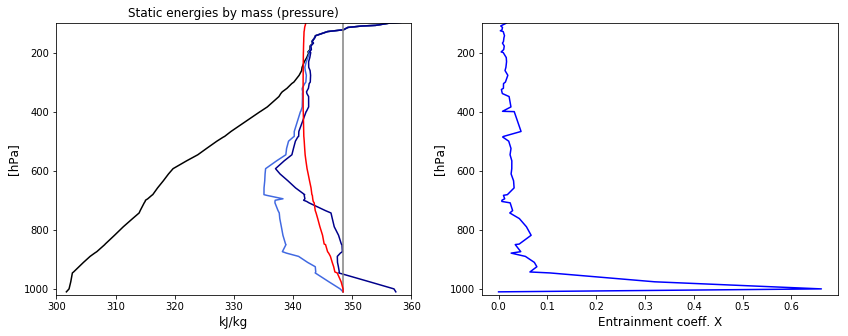

In [22]:
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(s/1000, p, 'k')
ax1.plot(h/1000,p,'royalblue')
ax1.plot(hs/1000, p, 'darkblue')
ax1.plot(h*0+h[0]/1000,p,'grey')
ax1.plot(hp_mix/1000,p,'r') # deep flow entrainment
xlabel('kJ/kg',fontsize=12);ylabel('[hPa]',fontsize=12)
xlim([300,360]); ylim([1020,100]); title('Static energies by mass (pressure)')

ax2 = plt.subplot(1,2,2)
ax2.plot(X,p,'b')
xlabel('Entrainment coeff. X',fontsize=12);ylabel('[hPa]',fontsize=12)
ylim([1020,100]); 

MSE invert not converging


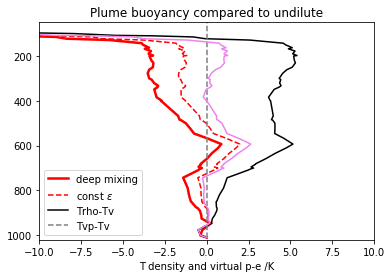

In [39]:
Tp_dmix,qvp_dmix = invert_MSE(hp_mix,qp_mix, np.where(Z<20000.,Z,20000.), np.where(p>50.,p,50.))
qcp_dmix = qp_mix - qvp_dmix

plot( Trho(Tp_dmix,qvp_dmix,qcp_dmix)-Tv(T,q) ,p, 'r',linewidth=2.5)
plot( Trho(Tplume,qvplume,qcplume)-Tv(T,q) ,p, '--r')
plot( Tv(TpMSE,qvpMSE)-Tv(T,q) ,p, 'k'); plot(p*0,p,'--',color='grey')

ylim([1020,50]); xlim([-10,10]); 
title('Plume buoyancy compared to undilute'); xlabel('T density and virtual p-e /K')
plt.legend(['deep mixing','const $\epsilon$','Trho-Tv','Tvp-Tv'])

plot( dTrho_MSE ,p ,'violet') # condensate loading

---------------
<a name="CAPE"></a>
### Determination of convective available potential energy (CAPE)
The buoyancy acceleration is in the form of 
\begin{equation*}
b = \frac{T_{vp}-T_v}{T_v}g
\end{equation*}
where g is gravity acceleration, 9.8m/s$^2$. T$_{vp}$ and T$_v$ are virtual temperature of 
the parcel and its environment, respectively.

The definition of CAPE is the vertical integrated buyancy
\begin{equation*}
CAPE = \int_{LFC}^{LNB}b \ \ dz
\end{equation*}
where LFC is the level of free convection (b>0), and LNB is the level of neutral buoyancy (b=0)

Text(0, 0.5, 'Z (km)')

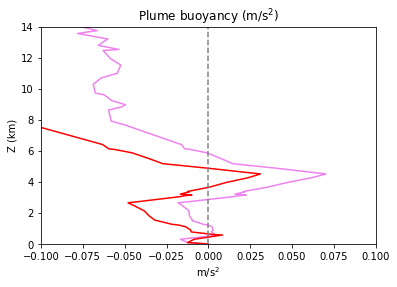

In [40]:
dTrho = Trho(Tplume,qvplume,qcplume)-Tv(T,q) # const mixing
dTrho_dmix = Trho(Tp_dmix,qvp_dmix,qcp_dmix)-Tv(T,q) # deep mixing

b = 9.8* dTrho/(Tv(T,q)+273.2)
b2 = 9.8* dTrho_dmix/(Tv(T,q)+273.2)

plot(b ,Z/1000,'violet'); plot(b2,Z/1000,'r')
plot(p*0,Z/1000,'--',color='grey')
ylim([0,14]); xlim([-0.1,0.1]); 
title('Plume buoyancy (m/s$^2$)'); xlabel('m/s$^2$'); ylabel('Z (km)')

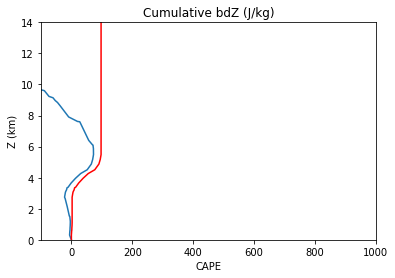

In [36]:
cumb = np.cumsum(b*dZ)
plot(cumb,Z/1000)
title('Cumulative bdZ (J/kg)'); xlabel('CAPE'); ylabel('Z (km)')
ylim([0,14]); xlim([-100,1000]); 

#cumbpos = np.cumsum( np.where((b>0 and Z<15000),b,0) *dZ)
cape = np.cumsum( np.where((b>0),b,0) *dZ)
#cin = np.cumsum( np.where())
plot(cape,Z/1000,'r')

cape_met, cine_met = cape_cin(p*units.units('mbar'),T*units.units('degC'),
                              Td*units.units('degC'),Tplume.magnitude*units.units('degC'))

In [38]:
cine_met

<Quantity(-8.612719062496206, 'joule / kilogram')>

-----------------
---------------
<a name="sens"></a>
# Sensitivity functional of CAPE to env T, Td

## $S_T = \partial(CAPE)/\partial(T_i)$ for each altitude's $T_i$
## $S_{T_d} = \partial(CAPE)/\partial(T_{d_i})$ for each altitude's $T_{d_i}$

In [172]:
# Let's use MetPy functions for this 

pp = p*units.units('hPa')
TT = T*units.units('degC')
DD = Td*units.units('degC')

parcel_profile = mpcalc.parcel_profile(pp, TT[0], DD[0])
# The parcel starts at `temperature`, and `dewpt`, lifted up
# dry adiabatically to the LCL, and then moist adiabatically from there.
# pressure` specifies the pressure levels for the profile.

CAPE,cin = mpcalc.cape_cin(pp, TT, DD, parcel_profile)
CAPE

<Quantity(1992.2802970779007, 'joule / kilogram')>

In [ ]:
# Create arrays to hold the result: dCAPE/dTd and dCAPE/dT

Tsens = p*0+CAPE*0  # empty array, size and units alright
Tdsens = p*0+CAPE*0 # empty array

# fill the T array first with 1K increments

for i in arange(size(p)): 
    print('T',i, p[i]) 
    T2 = T.copy(); T2[i] += 1.0; TT2 = T2*units.units('degC')
    parcel_profile = mpcalc.parcel_profile(pp, TT2[0], DD[0])
    CAPE2,cin2 = mpcalc.cape_cin(pp, TT2, DD, parcel_profile)
    Tsens[i] = CAPE2-CAPE
    print(CAPE2,CAPE)
    
# Fill the dCAPE/dTd array
for i in arange(size(p)): 
    print('Td',i, p[i]) 
    D2 = Td.copy(); D2[i] += 1.0; DD2 = D2*units.units('degC')
    parcel_profile = mpcalc.parcel_profile(pp, TT[0], DD2[0])
    CAPE2,cin2 = mpcalc.cape_cin(pp, TT, DD2, parcel_profile)
    Tdsens[i] = CAPE2-CAPE
    print(CAPE2,CAPE)


In [ ]:
plot(Tsens,Z/1000,'b')
plot(Tdsens,Z/1000,'r')

title('d(CAPE)/dT (J/kg/K) and d(CAPE)/dTd (J/kg/K)'); xlabel('CAPE change for +1K'); ylabel('height [km]')
ylim([0,16]); xlim([-100,100]); 


In [ ]:
Tsens

<a href="#top">Top</a>
<hr style="height:2px;">